## 패키지 가져오기

In [1]:
from pykrx import stock
import pandas_datareader.data as web
from talib import BBANDS, RSI, MACD

import pandas as pd
import numpy as np

import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pykrx import stock
from pykrx import bond
import pandas_datareader.data as web
import FinanceDataReader as fdr

from talib import RSI, BBANDS, MACD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
import time
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool, Manager

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_cores = mp.cpu_count()
print(f"사용가능한 코어 수: {num_cores}")

사용가능한 코어 수: 8


## RSI 전략(30 Long Only)

14일을 기준으로 RSI를 계산하고, RSI가 10 이상 30 이하면 초과매도국면으로 판단하여 매수하는 전략  
이 때, 각 자산의 매수 및 매도 비중은 모두 동일 가중 방식을 사용하여 결정. 한편, 리밸런싱 주기는 5일로 설정.  
한편, 자산의 수가 적어 개별 자산의 비중이 지나치게 높아지는 것을 방지하기 위해 각 자산 별 최대 비중은 0.2로 제한  
2013년 2월~2023년 2월에 리밸런싱 시점에 코스피200에 있는 주식들을 대상으로 실행

2013년 2월~2023년 2월 동안 2%의 저조한 수익률을 기록

In [3]:
start_date, end_date = "2013-01-01","2023-03-02"
rebalance_period = 5
rebalance_date = stock.get_market_ohlcv(start_date, end_date, "005930").index[::rebalance_period]
rebalance_date = rebalance_date.strftime("%Y-%m-%d")

In [4]:
#각 시점에서 marketcap 상위 200위인 주식들의 정보를 가져옴
# 각 시점에서 marketcap 상위 200위인 주식들의 정보는 rebalance_dict에
# 한번이라도 상위 200위였던 종목들의 정보를 all_tickers에 담음
all_tickers = []
rebalance_dict = {}
for date in tqdm(rebalance_date):
    marketcap = stock.get_market_cap(date, market='KOSPI')
    kospi200 = marketcap.sort_values(by='시가총액', ascending=False).head(200).index.tolist()
    rebalance_dict[date] = kospi200
    all_tickers += kospi200
rebalance_df = pd.DataFrame(rebalance_dict)
all_tickers = list(set(all_tickers))

100%|██████████| 501/501 [04:16<00:00,  1.96it/s]


In [5]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('price_df(200).csv')

price_df = pd.read_csv('price_df(200).csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

100%|██████████| 407/407 [00:34<00:00, 11.83it/s]


,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,14400,35077,1285,24450.0,8450.0,10150,43500,4805,13247,...,6400,0.0,0.0,8800,75000,56300,38800,0.0,71413,1530
2013-01-03,0.0,13700,37372,1330,24000.0,8380.0,10200,44750,4915,12487,...,6450,0.0,0.0,8860,75700,54600,39300,0.0,69372,1443
2013-01-04,0.0,14550,37565,1335,24150.0,8350.0,10400,44700,4805,12921,...,6470,0.0,0.0,8800,74800,53600,39150,0.0,71099,1420
2013-01-07,0.0,14400,37641,1320,24400.0,8300.0,10600,44500,4825,11672,...,6920,0.0,0.0,8580,74100,54000,39850,0.0,75336,1461
2013-01-08,0.0,14950,36263,1295,24100.0,8310.0,10600,43400,4815,11999,...,7060,0.0,0.0,8530,72000,54500,38750,0.0,74395,1498


In [6]:
# RSI 계산
# timeperiod=14를 사용
rsi = price_df.copy()
for col in price_df.columns:
    rsi[col] = RSI(price_df[col], timeperiod=14)
rsi = rsi.fillna(0)

In [7]:
# 롱온리 포트폴리오를 만듬
# RSI 10 이상 30 이하면 매수
# 최대비중은 0.1로 제한
def calculate_weights(rsi, long1=10, long2 = 30):
    signal = rsi.copy()
    for i in tqdm(range(len(rebalance_date)-1)):
        day1, day2 = rebalance_date[i], rebalance_date[i+1]
        temp = rsi.loc[[rebalance_date[i], rebalance_date[i+1]], 
                   list(set(rebalance_df[rebalance_date[i]]) & set(rebalance_df[rebalance_date[i+1]]))]
        for j in range(len(temp.columns)):
            if (long1 <= temp.iloc[0, j] <= long2):
                signal.loc[temp.index[1], temp.columns[j]] = 1
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        long_cnt = np.sum(long_signal)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        long_signal = np.clip(long_signal, 0, 0.2)
        return long_signal
    signal = signal.apply(calculate_weights_from_signal, axis=1)
    return signal
weights = calculate_weights(rsi) 

100%|██████████| 500/500 [00:04<00:00, 116.03it/s]


In [8]:
# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [9]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-23,-0.017068,-0.011596,-0.000612,-0.001528,0.0,0.0,-0.009101,-0.007421,-0.005008,-0.031442,...,-0.018066,0.004695,-0.001638,-0.011307,0.001186,-0.014398,0.014000,0.006807,-0.025761,-0.010539
2023-02-24,-0.041879,0.007821,-0.003676,0.002295,0.0,0.0,0.000000,-0.003738,-0.035794,-0.027523,...,-0.014069,-0.007009,-0.025431,-0.018424,-0.026066,0.009296,-0.001972,0.022127,0.000000,0.000000
2023-02-27,0.047974,0.001109,0.000000,-0.005344,0.0,0.0,0.008037,0.001876,-0.006381,-0.009434,...,-0.005488,0.002353,0.038721,0.007767,-0.010949,-0.009211,0.013834,0.021046,0.002404,0.000592
2023-02-28,-0.040692,0.033776,0.019680,0.002302,0.0,0.0,0.045558,-0.005618,-0.007589,-0.010989,...,-0.012141,0.021127,-0.012156,-0.004496,0.017220,0.033201,-0.013645,-0.012956,-0.011990,-0.001183
2023-03-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2013-02-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2013-02-01,-0.005950
2013-02-04,-0.018036
2013-02-05,0.001171
2013-02-06,-0.008894
2013-02-07,0.014496
...,...
2023-02-21,-0.011586
2023-02-22,0.001647
2023-02-23,-0.000969


In [11]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2013-02-01,-0.005950
2013-02-04,-0.023878
2013-02-05,-0.022735
2013-02-06,-0.031427
2013-02-07,-0.017386
...,...
2023-02-21,-0.128244
2023-02-22,-0.126809
2023-02-23,-0.127655


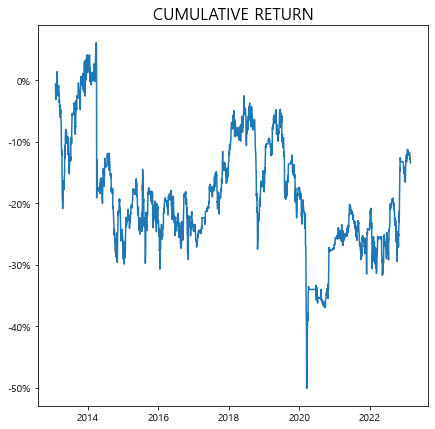

In [12]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## RSI 전략(50 상향돌파 Long Only)

14일을 기준으로 RSI를 계산하고, RSI가 50을 상향돌파하면 매수. 
이 때, 각 자산의 매수 및 매도 비중은 모두 동일 가중 방식을 사용하여 결정. 한편, 리밸런싱 주기는 5일로 설정.  
한편, 자산의 수가 적어 개별 자산의 비중이 지나치게 높아지는 것을 방지하기 위해 각 자산 별 최대 비중은 0.2로 제한  
2013년 2월~2023년 2월에 리밸런싱 시점에 코스피200에 있는 주식들을 대상으로 실행

2013년 2월~2023년 2월 동안 -26%의 저조한 수익률을 기록

In [13]:
price_df = pd.read_csv('price_df(200).csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,14400,35077,1285,24450.0,8450.0,10150,43500,4805,13247,...,6400,0.0,0.0,8800,75000,56300,38800,0.0,71413,1530
2013-01-03,0.0,13700,37372,1330,24000.0,8380.0,10200,44750,4915,12487,...,6450,0.0,0.0,8860,75700,54600,39300,0.0,69372,1443
2013-01-04,0.0,14550,37565,1335,24150.0,8350.0,10400,44700,4805,12921,...,6470,0.0,0.0,8800,74800,53600,39150,0.0,71099,1420
2013-01-07,0.0,14400,37641,1320,24400.0,8300.0,10600,44500,4825,11672,...,6920,0.0,0.0,8580,74100,54000,39850,0.0,75336,1461
2013-01-08,0.0,14950,36263,1295,24100.0,8310.0,10600,43400,4815,11999,...,7060,0.0,0.0,8530,72000,54500,38750,0.0,74395,1498


In [14]:
# RSI 계산
# timeperiod=14를 사용
rsi = price_df.copy()
for col in price_df.columns:
    rsi[col] = RSI(price_df[col], timeperiod=14)
rsi = rsi.fillna(0)

In [15]:
def calculate_weights(rsi, long=50):
    signal = rsi.copy()
    for i in tqdm(range(len(rebalance_date)-1)):
        day1, day2 = rebalance_date[i], rebalance_date[i+1]
        temp = rsi.loc[[rebalance_date[i], rebalance_date[i+1]], 
                   list(set(rebalance_df[rebalance_date[i]]) & set(rebalance_df[rebalance_date[i+1]]))]
        for j in range(len(temp.columns)):
            if (temp.iloc[0, j] < long) & (temp.iloc[1, j] >= long):
                signal.loc[temp.index[1], temp.columns[j]] = 1
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        long_cnt = np.sum(long_signal)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        long_signal = np.clip(long_signal, 0, 0.2)
        return long_signal
    signal = signal.apply(calculate_weights_from_signal, axis=1)
    return signal
weights = calculate_weights(rsi)

100%|██████████| 500/500 [00:09<00:00, 53.02it/s]


In [16]:
# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [17]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2013-02-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2013-02-01,0.004222
2013-02-04,-0.013938
2013-02-05,0.004558
2013-02-06,-0.016597
2013-02-07,-0.000320
...,...
2023-02-21,-0.007932
2023-02-22,0.005488
2023-02-23,-0.012063


In [18]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2013-02-01,0.004222
2013-02-04,-0.009774
2013-02-05,-0.005261
2013-02-06,-0.021770
2013-02-07,-0.022084
...,...
2023-02-21,-0.247600
2023-02-22,-0.243471
2023-02-23,-0.252597


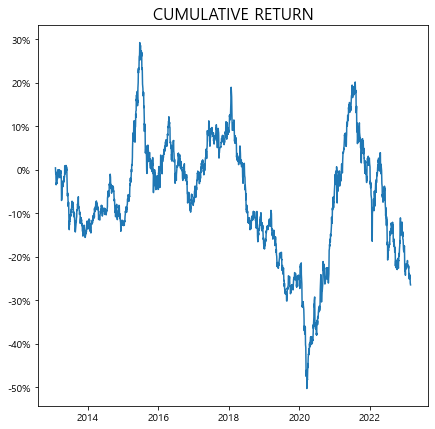

In [19]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## MACD 전략(상향돌파 Long Only)

12일을 단기 이동평균, 26일 중기 이동평균으로 사용  
단기 이동평균과 중기 이동평균의 차이를 MACD Signal이라고 하고, MACD Signal의 9일 이동평균선을 사용
만약 MACD가 MACD Signal보다 높으면 매수를 함.   
이 때, MACD Signal이 양수인 것 중 가장 높은 20개(최대)를 동일 가중을 사용해 매수하되,   
각 자산의 최대 비중은 0.2로 설정.  
리밸런싱 주기는 5일

해당 기간동안 41% 정도의 수익률을 기록

In [20]:
price_df = pd.read_csv('price_df(200).csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,14400,35077,1285,24450.0,8450.0,10150,43500,4805,13247,...,6400,0.0,0.0,8800,75000,56300,38800,0.0,71413,1530
2013-01-03,0.0,13700,37372,1330,24000.0,8380.0,10200,44750,4915,12487,...,6450,0.0,0.0,8860,75700,54600,39300,0.0,69372,1443
2013-01-04,0.0,14550,37565,1335,24150.0,8350.0,10400,44700,4805,12921,...,6470,0.0,0.0,8800,74800,53600,39150,0.0,71099,1420
2013-01-07,0.0,14400,37641,1320,24400.0,8300.0,10600,44500,4825,11672,...,6920,0.0,0.0,8580,74100,54000,39850,0.0,75336,1461
2013-01-08,0.0,14950,36263,1295,24100.0,8310.0,10600,43400,4815,11999,...,7060,0.0,0.0,8530,72000,54500,38750,0.0,74395,1498


In [21]:
fastperiod = 12
slowperiod = 26
signalperiod = 9

macd_df = price_df.copy()
macd_signal_df = price_df.copy()
macd_hist_df = price_df.copy()

for col in price_df.columns:
    macd,macd_signal, macd_hist = MACD(price_df[col], fastperiod=fastperiod, 
                                       slowperiod=slowperiod, signalperiod=signalperiod)
    macd_df[col], macd_signal_df[col], macd_hist_df[col] = macd, macd_signal, macd_hist

In [22]:
macd_signal_df = macd_signal_df.fillna(0)
def calculate_weights(macd_signal_df, long=20):
    long_signal = ((macd_signal_df
                  .where(macd_signal_df > 0)
                  .rank(axis=1, ascending=False) <= long)
                  .astype(int))
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        long_cnt = np.sum((arr == 1))
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        long_signal = np.clip(long_signal, 0, 0.1)
        return long_signal
    long_signal = long_signal.apply(calculate_weights_from_signal, axis=1)
    return long_signal
weights = calculate_weights(macd_signal_df)
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [23]:
# rebalance를 반영해서 weight를 수정
rebalance_date = pd.to_datetime(rebalance_date, format='%Y-%m-%d')
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [24]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-23,-0.017068,-0.011596,-0.000612,-0.001528,0.0,0.0,-0.009101,-0.007421,-0.005008,-0.031442,...,-0.018066,0.004695,-0.001638,-0.011307,0.001186,-0.014398,0.014000,0.006807,-0.025761,-0.010539
2023-02-24,-0.041879,0.007821,-0.003676,0.002295,0.0,0.0,0.000000,-0.003738,-0.035794,-0.027523,...,-0.014069,-0.007009,-0.025431,-0.018424,-0.026066,0.009296,-0.001972,0.022127,0.000000,0.000000
2023-02-27,0.047974,0.001109,0.000000,-0.005344,0.0,0.0,0.008037,0.001876,-0.006381,-0.009434,...,-0.005488,0.002353,0.038721,0.007767,-0.010949,-0.009211,0.013834,0.021046,0.002404,0.000592
2023-02-28,-0.040692,0.033776,0.019680,0.002302,0.0,0.0,0.045558,-0.005618,-0.007589,-0.010989,...,-0.012141,0.021127,-0.012156,-0.004496,0.017220,0.033201,-0.013645,-0.012956,-0.011990,-0.001183
2023-03-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2013-02-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2013-02-01,0.000000
2013-02-04,0.000000
2013-02-05,0.000000
2013-02-06,0.000000
2013-02-07,0.000000
...,...
2023-02-21,-0.013935
2023-02-22,0.003345
2023-02-23,-0.009927


In [27]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2013-02-01,0.000000
2013-02-04,0.000000
2013-02-05,0.000000
2013-02-06,0.000000
2013-02-07,0.000000
...,...
2023-02-21,0.422977
2023-02-22,0.427737
2023-02-23,0.413564


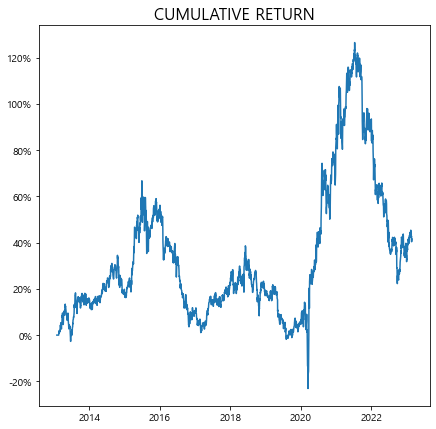

In [28]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## BBANDS 전략(2시그마 Long Only)

볼린저밴드에서 2 시그마보다 낮으면 매수하는 전략  
이 때, 자산 별 비중은 동일 가중 방식을 사용해 설정. 단, 각 자산의 최대비중은 0.2  
리밸런싱 주기는 5일  

해당 기간 동안 -16.5% 정도의 수익률을 기록

In [29]:
price_df = pd.read_csv('price_df(200).csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,14400,35077,1285,24450.0,8450.0,10150,43500,4805,13247,...,6400,0.0,0.0,8800,75000,56300,38800,0.0,71413,1530
2013-01-03,0.0,13700,37372,1330,24000.0,8380.0,10200,44750,4915,12487,...,6450,0.0,0.0,8860,75700,54600,39300,0.0,69372,1443
2013-01-04,0.0,14550,37565,1335,24150.0,8350.0,10400,44700,4805,12921,...,6470,0.0,0.0,8800,74800,53600,39150,0.0,71099,1420
2013-01-07,0.0,14400,37641,1320,24400.0,8300.0,10600,44500,4825,11672,...,6920,0.0,0.0,8580,74100,54000,39850,0.0,75336,1461
2013-01-08,0.0,14950,36263,1295,24100.0,8310.0,10600,43400,4815,11999,...,7060,0.0,0.0,8530,72000,54500,38750,0.0,74395,1498


In [30]:
# timeperiod=21, sigma=2로 설정
def calculate_weights(price_df, timeperiod=21, sigma=2):
    high_df, mid_df, low_df = price_df.copy(), price_df.copy(), price_df.copy()
    for col in price_df.columns:
        high, mid, low = BBANDS(price_df[col], timeperiod=timeperiod, nbdevup=sigma, nbdevdn=sigma, matype=0)
        high_df[col], mid_df[col], low_df[col] = high, mid, low
    long_signal = (price_df < low_df).astype(int)
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        long_cnt = np.sum(arr == 1)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        long_signal = np.clip(long_signal, 0, 0.2)
        return long_signal
    long_signal = long_signal.apply(calculate_weights_from_signal, axis=1)
    return long_signal
weights = calculate_weights(price_df)
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [31]:
# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [32]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-23,-0.017068,-0.011596,-0.000612,-0.001528,0.0,0.0,-0.009101,-0.007421,-0.005008,-0.031442,...,-0.018066,0.004695,-0.001638,-0.011307,0.001186,-0.014398,0.014000,0.006807,-0.025761,-0.010539
2023-02-24,-0.041879,0.007821,-0.003676,0.002295,0.0,0.0,0.000000,-0.003738,-0.035794,-0.027523,...,-0.014069,-0.007009,-0.025431,-0.018424,-0.026066,0.009296,-0.001972,0.022127,0.000000,0.000000
2023-02-27,0.047974,0.001109,0.000000,-0.005344,0.0,0.0,0.008037,0.001876,-0.006381,-0.009434,...,-0.005488,0.002353,0.038721,0.007767,-0.010949,-0.009211,0.013834,0.021046,0.002404,0.000592
2023-02-28,-0.040692,0.033776,0.019680,0.002302,0.0,0.0,0.045558,-0.005618,-0.007589,-0.010989,...,-0.012141,0.021127,-0.012156,-0.004496,0.017220,0.033201,-0.013645,-0.012956,-0.011990,-0.001183
2023-03-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2013-02-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2013-02-01,-0.005710
2013-02-04,0.003677
2013-02-05,0.001713
2013-02-06,-0.003285
2013-02-07,0.012565
...,...
2023-02-21,-0.016792
2023-02-22,0.004697
2023-02-23,-0.005876


In [34]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2013-02-01,-0.005710
2013-02-04,-0.002054
2013-02-05,-0.000345
2013-02-06,-0.003629
2013-02-07,0.008890
...,...
2023-02-21,-0.172994
2023-02-22,-0.169110
2023-02-23,-0.173992


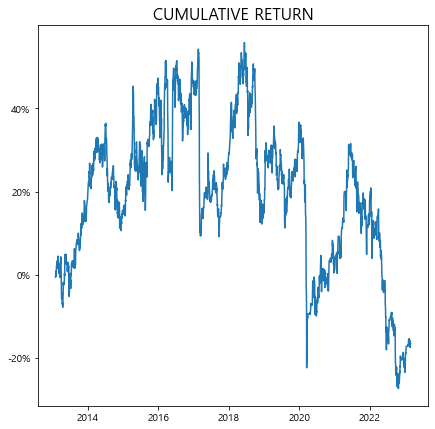

In [35]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## BBANDS 전략(1~1.5시그마 Long Only)

볼린저밴드에서 1~1.5 시그마 만큼 낮으면 매수하는 전략  
이 때, 자산 별 비중은 동일 가중 방식을 사용해 설정. 단, 각 자산의 최대비중은 0.2  
리밸런싱주기는 5일

해당 기간동안 -1% 정도의 수익률을 기록

In [36]:
price_df = pd.read_csv('price_df(200).csv', index_col=0)
price_df = price_df.fillna(0)
price_df.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,14400,35077,1285,24450.0,8450.0,10150,43500,4805,13247,...,6400,0.0,0.0,8800,75000,56300,38800,0.0,71413,1530
2013-01-03,0.0,13700,37372,1330,24000.0,8380.0,10200,44750,4915,12487,...,6450,0.0,0.0,8860,75700,54600,39300,0.0,69372,1443
2013-01-04,0.0,14550,37565,1335,24150.0,8350.0,10400,44700,4805,12921,...,6470,0.0,0.0,8800,74800,53600,39150,0.0,71099,1420
2013-01-07,0.0,14400,37641,1320,24400.0,8300.0,10600,44500,4825,11672,...,6920,0.0,0.0,8580,74100,54000,39850,0.0,75336,1461
2013-01-08,0.0,14950,36263,1295,24100.0,8310.0,10600,43400,4815,11999,...,7060,0.0,0.0,8530,72000,54500,38750,0.0,74395,1498


In [37]:
# timeperiod=21, sigma1=1, sigma2=1.5로 설정
def calculate_weights(price_df, timeperiod=21, sigma1=1, sigma2=1.5):
    high_1_df, mid_1_df, low_1_df = price_df.copy(), price_df.copy(), price_df.copy()
    high_2_df, mid_2_df, low_2_df = price_df.copy(), price_df.copy(), price_df.copy()
    for col in price_df.columns:
        high_1, mid_1, low_1 = BBANDS(price_df[col], timeperiod=timeperiod, nbdevup=sigma1, nbdevdn=sigma1, matype=0)
        high_1_df[col], mid_1_df[col], low_1_df[col] = high_1, mid_1, low_1
        
        high_2, mid_2, low_2 = BBANDS(price_df[col], timeperiod=timeperiod, nbdevup=sigma2, nbdevdn=sigma2, matype=0)
        high_2_df[col], mid_2_df[col], low_2_df[col] = high_2, mid_2, low_2
    long_signal = ((price_df < low_1_df) & (price_df > low_2_df)).astype(int)
    def calculate_weights_from_signal(arr):
        long_signal = (arr == 1).astype(int)
        long_cnt = np.sum(arr == 1)
        if long_cnt > 0:
            long_signal = long_signal / long_cnt
        long_signal = np.clip(long_signal, 0, 0.2)
        return long_signal
    long_signal = long_signal.apply(calculate_weights_from_signal, axis=1)
    return long_signal
weights = calculate_weights(price_df)
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [38]:
# rebalance를 반영해서 weight를 수정
for date in weights.index:
    if date not in rebalance_date:
        weights.loc[date, :] = np.nan
weights = weights.fillna(method='ffill')
weights.index = pd.to_datetime(weights.index, format='%Y-%m-%d')

In [39]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.tail()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2023-02-23,-0.017068,-0.011596,-0.000612,-0.001528,0.0,0.0,-0.009101,-0.007421,-0.005008,-0.031442,...,-0.018066,0.004695,-0.001638,-0.011307,0.001186,-0.014398,0.014000,0.006807,-0.025761,-0.010539
2023-02-24,-0.041879,0.007821,-0.003676,0.002295,0.0,0.0,0.000000,-0.003738,-0.035794,-0.027523,...,-0.014069,-0.007009,-0.025431,-0.018424,-0.026066,0.009296,-0.001972,0.022127,0.000000,0.000000
2023-02-27,0.047974,0.001109,0.000000,-0.005344,0.0,0.0,0.008037,0.001876,-0.006381,-0.009434,...,-0.005488,0.002353,0.038721,0.007767,-0.010949,-0.009211,0.013834,0.021046,0.002404,0.000592
2023-02-28,-0.040692,0.033776,0.019680,0.002302,0.0,0.0,0.045558,-0.005618,-0.007589,-0.010989,...,-0.012141,0.021127,-0.012156,-0.004496,0.017220,0.033201,-0.013645,-0.012956,-0.011990,-0.001183
2023-03-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
# 일별 수익률 계산
daily_return = weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2013-02-01") & (daily_return.index < "2023-02-28")]
daily_return = daily_return.to_frame("daily_return")
daily_return

,daily_return
날짜,
2013-02-01,-0.005316
2013-02-04,-0.007174
2013-02-05,0.007696
2013-02-06,-0.004754
2013-02-07,0.000030
...,...
2023-02-21,-0.015173
2023-02-22,0.002611
2023-02-23,-0.003538


In [41]:
# 누적수익률 계산
cumulative_return = np.exp(np.log(daily_return['daily_return'] + 1).cumsum())-1
cumulative_return = cumulative_return.to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2013-02-01,-0.005316
2013-02-04,-0.012452
2013-02-05,-0.004852
2013-02-06,-0.009582
2013-02-07,-0.009553
...,...
2023-02-21,-0.009734
2023-02-22,-0.007148
2023-02-23,-0.010661


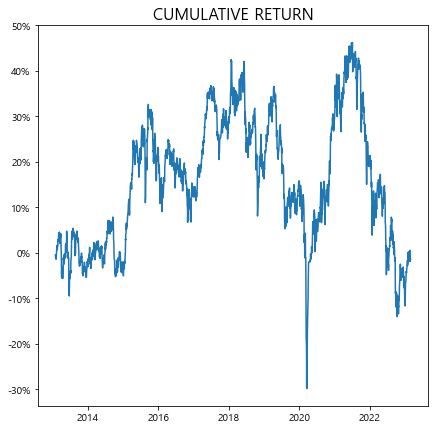

In [42]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## 모멘텀(1,3,6 개월 Long Only)

최근 1,3,6개월의 수익률이 높은 주식을 매수하는 전략(Long Only)  
각 자산의 매수 및 매도 비중은 동일 가중 방식을 사용하여 결정. 리밸런싱 주기는 1개월로 설정.   
이 때, 수익률이 양수이면서 높은 주식을 최대 20개까지 매수하되, 각 자산의 최대 비중은 0.2로 설정.  
리밸런싱 주기는 1개월로 설정.

In [43]:
# 1개월을 기준으로 rebalancing을 실시
start_date, end_date = "2012-02-01", "2023-03-01"
all_dates = stock.get_market_ohlcv(start_date, end_date, "005930").index
all_dates = all_dates.to_frame('Dates').resample("M").first()['날짜'].tolist()
all_dates = [x.strftime("%Y-%m-%d") for x in rebalance_date]

In [44]:
#각 시점에서 marketcap 상위 200위인 주식들의 정보를 가져옴
# 각 시점에서 marketcap 상위 200위인 주식들의 정보는 rebalance_dict에
# 한번이라도 상위 200위였던 종목들의 정보를 all_tickers에 담음
all_tickers = []
rebalance_dict = {}
for date in tqdm(all_dates):
    marketcap = stock.get_market_cap(date, market='KOSPI')
    kospi200 = marketcap.sort_values(by='시가총액', ascending=False).head(200).index.tolist()
    rebalance_dict[date] = kospi200
    all_tickers += kospi200
rebalance_df = pd.DataFrame(rebalance_dict)
all_tickers = list(set(all_tickers))

100%|██████████| 501/501 [02:57<00:00,  2.82it/s]


In [45]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('momentum_price_df(200).csv')

100%|██████████| 407/407 [00:42<00:00,  9.68it/s]


In [46]:
price_df = pd.read_csv('momentum_price_df(200).csv', index_col=0)
price_df = price_df.fillna(0)
price_df.index = pd.to_datetime(price_df.index, format='%Y-%m-%d')
price_df.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2012-02-01,0.0,19950,53324,914,25100.0,9070.0,12950,40000,2856,8035,...,9720,0.0,0.0,10500,64300,66900,42150,0.0,65919,3779
2012-02-02,0.0,20250,54853,924,25750.0,9210.0,12950,40400,2856,8035,...,9500,0.0,0.0,9970,66100,66700,43400,0.0,66076,3886
2012-02-03,0.0,19950,55389,935,25600.0,9150.0,12650,40500,2826,7893,...,9200,0.0,0.0,9700,69000,66400,43900,0.0,68274,3899
2012-02-06,0.0,19150,57379,873,26000.0,9200.0,12800,39900,2836,8046,...,8900,0.0,0.0,9540,68600,65100,44100,0.0,69215,3800
2012-02-07,0.0,19250,56767,880,26500.0,9130.0,13150,38000,2865,7926,...,8920,0.0,0.0,9640,68800,67100,43450,0.0,68587,3870


In [47]:
momentum_1 = price_df.resample("M").last().pct_change(1).replace(np.inf,0).fillna(0).iloc[1:, :]
momentum_3 = price_df.resample("M").last().pct_change(3).replace(np.inf, 0).fillna(0).iloc[3:, :]
momentum_6 = price_df.resample("M").last().pct_change(6).replace(np.inf, 0).fillna(0).iloc[6:, :]
momentum_9 = price_df.resample("M").last().pct_change(9).replace(np.inf, 0).fillna(0).iloc[9:, :]
momentum_12 = price_df.resample("M").last().pct_change(12).replace(np.inf, 0).fillna(0).iloc[12:, :]

In [48]:
def change_period(df):
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df[df.index >= "2013-02-01"]
    return df
momentum_1 = change_period(momentum_1)
momentum_3 = change_period(momentum_3)
momentum_6 = change_period(momentum_6)
momentum_9 = change_period(momentum_9)
momentum_12 = change_period(momentum_12)
price_df = price_df[price_df.index >= "2013-02-01"]

In [49]:
def calculate_weights(momentum_df, long=20):
    long_signal = ((momentum_df
                  .where(momentum_df > 0)
                  .rank(axis=1, ascending=False) <= long)
                  .astype(int))
    def calculate_weights_from_signal(arr):
        signal = (arr == 1).astype(int)
        cnt = np.clip(np.sum(arr == 1), 0, long)
        if cnt > 0:
            signal = signal / cnt
        signal = np.clip(signal, 0, 0.2)
        return signal
    long_signal = long_signal.apply(calculate_weights_from_signal, axis=1)
    return long_signal

In [50]:
momentum_1_weights = calculate_weights(momentum_1)
momentum_3_weights = calculate_weights(momentum_3)
momentum_6_weights = calculate_weights(momentum_6)
momentum_9_weights = calculate_weights(momentum_9)
momentum_12_weights = calculate_weights(momentum_12)

In [51]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-02-01,0.0,0.036545,0.001161,0.067797,0.002000,-0.009535,-0.023810,0.008520,-0.024415,0.052824,...,-0.001548,0.0,0.0,-0.016129,-0.004292,-0.025000,-0.002577,0.0,-0.012199,0.052632
2013-02-04,0.0,0.006410,-0.008145,0.035714,-0.019960,-0.009627,-0.028293,-0.009504,-0.002086,-0.004162,...,-0.027907,0.0,0.0,0.018735,-0.007184,0.005917,-0.014212,0.0,-0.047327,-0.006757
2013-02-05,0.0,0.063694,-0.007074,0.007663,0.024440,0.002430,0.004016,-0.005330,0.004180,-0.004179,...,0.006380,0.0,0.0,-0.010345,0.007236,-0.020588,-0.009174,0.0,-0.021591,0.003401
2013-02-06,0.0,-0.026946,-0.022518,0.007605,-0.017893,-0.001212,0.010000,-0.001072,-0.002081,0.016787,...,0.003170,0.0,0.0,-0.018583,-0.002874,-0.001001,-0.013228,0.0,0.030901,-0.027797
2013-02-07,0.0,0.003077,-0.001236,0.011321,0.004049,0.003641,-0.009901,-0.001073,0.008342,-0.099518,...,0.007899,0.0,0.0,-0.008284,-0.008646,0.044088,0.006702,0.0,0.010710,-0.016039


In [52]:
def change_weight_period(fwd_return, momentum_weights):
    temp_weights = fwd_return.copy()
    for i in range(len(momentum_weights.index)-1):
        day1 = momentum_weights.index[i]
        day2 = momentum_weights.index[i+1]
        temp = momentum_weights.iloc[i,:]
        temp_weights[(temp_weights.index >= day1) & (temp_weights.index < day2)] = temp
    return temp_weights

In [53]:
momentum_1_weights = change_weight_period(fwd_return, momentum_1_weights)
momentum_3_weights = change_weight_period(fwd_return, momentum_3_weights)
momentum_6_weights = change_weight_period(fwd_return, momentum_6_weights)
momentum_9_weights = change_weight_period(fwd_return, momentum_9_weights)
momentum_12_weights = change_weight_period(fwd_return, momentum_12_weights)

In [54]:
# 일별 수익률 계산
daily_return = pd.DataFrame()
daily_return['momentum_1'] = momentum_1_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_3'] = momentum_3_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_6'] = momentum_6_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_9'] = momentum_9_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_12'] = momentum_12_weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2015-03-01") & (daily_return.index < "2023-02-28")]
daily_return.head()

,momentum_1,momentum_3,momentum_6,momentum_9,momentum_12
날짜,,,,,
2015-03-02,0.004529,0.000454,0.000985,-0.006622,-0.002083
2015-03-03,0.001594,-0.007669,-0.011152,-0.010562,-0.007253
2015-03-04,0.007677,-0.001133,-0.005202,-0.004689,-0.002072
2015-03-05,0.011265,-0.001314,-0.000827,0.002068,0.005091
2015-03-06,-0.018124,-0.010020,-0.007518,-0.014750,-0.018417


In [55]:
cumulative_return = daily_return.copy()
for col in cumulative_return.columns:
    cumulative_return[col] = np.exp(np.log(daily_return[col]+1).cumsum())-1
cumulative_return

,momentum_1,momentum_3,momentum_6,momentum_9,momentum_12
날짜,,,,,
2015-03-02,0.004529,0.000454,0.000985,-0.006622,-0.002083
2015-03-03,0.006131,-0.007219,-0.010179,-0.017114,-0.009320
2015-03-04,0.013855,-0.008343,-0.015328,-0.021722,-0.011373
2015-03-05,0.025277,-0.009647,-0.016142,-0.019699,-0.006340
2015-03-06,0.006695,-0.019570,-0.023539,-0.034159,-0.024640
...,...,...,...,...,...
2023-02-21,2.264851,1.630597,1.865019,1.396427,1.427379
2023-02-22,2.281013,1.643071,1.898528,1.443976,1.447063
2023-02-23,2.245240,1.636786,1.902610,1.434311,1.444778


<Figure size 720x720 with 0 Axes>

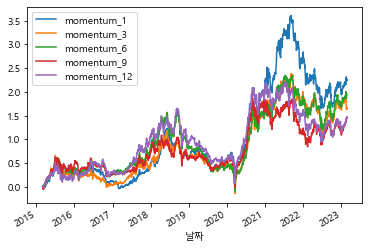

In [56]:
plt.figure(figsize=(10,10))
cumulative_return.plot()
plt.show()

## 모멘텀(5, 10일 Long Only)

위의 모메텀 전략과 동일하지만 5일 모멘텀과 10일 모멘텀을 사용하기로 함.  
리밸런싱 주기는 5일로 설정하고, 다른 모든 방식은 동일

In [57]:
start_date, end_date = "2013-01-01","2023-03-02"
rebalance_period = 5
rebalance_dates = stock.get_market_ohlcv(start_date, end_date, "005930").index[::rebalance_period]

In [58]:
price_df = pd.read_csv('price_df(200).csv', index_col=0)
price_df = price_df.fillna(0)
price_df.index = pd.to_datetime(price_df.index, format='%Y-%m-%d')
price_df.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,14400,35077,1285,24450.0,8450.0,10150,43500,4805,13247,...,6400,0.0,0.0,8800,75000,56300,38800,0.0,71413,1530
2013-01-03,0.0,13700,37372,1330,24000.0,8380.0,10200,44750,4915,12487,...,6450,0.0,0.0,8860,75700,54600,39300,0.0,69372,1443
2013-01-04,0.0,14550,37565,1335,24150.0,8350.0,10400,44700,4805,12921,...,6470,0.0,0.0,8800,74800,53600,39150,0.0,71099,1420
2013-01-07,0.0,14400,37641,1320,24400.0,8300.0,10600,44500,4825,11672,...,6920,0.0,0.0,8580,74100,54000,39850,0.0,75336,1461
2013-01-08,0.0,14950,36263,1295,24100.0,8310.0,10600,43400,4815,11999,...,7060,0.0,0.0,8530,72000,54500,38750,0.0,74395,1498


In [59]:
momentum_5d = price_df.pct_change(5).replace(np.inf, 0).fillna(0).iloc[5:, :]
momentum_10d = price_df.pct_change(10).replace(np.inf, 0).fillna(0).iloc[10:, :]

def change_period(df):
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df[df.index >= "2013-02-01"]
    return df
momentum_5d = change_period(momentum_5d)
momentum_10d = change_period(momentum_10d)
momentum_5d.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-02-01,0.0,0.010067,-0.061400,-0.059761,-0.038462,0.009627,0.004785,0.012945,-0.016016,-0.034018,...,-0.035821,0.0,0.0,0.016393,0.018950,0.045226,-0.017722,0.0,-0.010063,-0.009859
2013-02-04,0.0,0.040000,-0.077525,0.016129,-0.049336,-0.023502,-0.009662,0.016094,-0.040040,0.017009,...,-0.025680,0.0,0.0,0.009456,0.002882,0.034694,-0.050307,0.0,-0.024104,0.042254
2013-02-05,0.0,0.060811,-0.085990,0.056680,-0.050290,-0.029481,-0.046890,0.021786,-0.034309,0.062495,...,-0.051437,0.0,0.0,0.024735,-0.008608,-0.009709,-0.043860,0.0,-0.045362,0.022253
2013-02-06,0.0,0.151724,-0.122666,0.052000,-0.034549,-0.028269,-0.033816,-0.001071,-0.032226,0.058054,...,-0.048265,0.0,0.0,-0.010345,-0.021097,-0.010891,-0.051443,0.0,-0.073617,0.022176
2013-02-07,0.0,0.090604,-0.113863,0.086066,-0.033268,-0.026005,-0.038095,-0.014799,-0.036181,0.021152,...,-0.033588,0.0,0.0,-0.025375,-0.022535,-0.034816,-0.041131,0.0,-0.031117,-0.018480


In [60]:
def calculate_weights(momentum_df, long=20):
    long_signal = ((momentum_df
                  .where(momentum_df > 0)
                  .rank(axis=1, ascending=False) <= long)
                  .astype(int))
    def calculate_weights_from_signal(arr):
        signal = (arr == 1).astype(int)
        cnt = np.clip(np.sum(arr == 1), 0, long)
        if cnt > 0:
            signal = signal / cnt
        signal = np.clip(signal, 0, 0.2)
        return signal
    long_signal = long_signal.apply(calculate_weights_from_signal, axis=1)
    return long_signal

In [61]:
momentum_5d_weights = calculate_weights(momentum_5d)
momentum_10d_weights = calculate_weights(momentum_10d)
momentum_5d_weights.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-02-01,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-04,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-05,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-06,0.0,0.05,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-07,0.0,0.05,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# rebalance를 반영해서 weight를 수정
for date in momentum_5d_weights.index:
    if date not in rebalance_dates:
        momentum_5d_weights.loc[date, :] = np.nan
        momentum_10d_weights.loc[date, :] = np.nan
momentum_5d_weights = momentum_5d_weights.fillna(method='ffill')
momentum_5d_weights.index = pd.to_datetime(momentum_5d_weights.index, format='%Y-%m-%d')
momentum_10d_weights = momentum_10d_weights.fillna(method='ffill')
momentum_10d_weights.index = pd.to_datetime(momentum_10d_weights.index, format='%Y-%m-%d')

In [63]:
# 수익률 계산
# NaN 값은 일단 0으로 처리
fwd_return = price_df.pct_change().shift(-1)
fwd_return = fwd_return.fillna(0)
fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')
fwd_return.head()

,336370,084870,034020,034830,002550,003457,010780,021240,003090,000230,...,000990,214320,381970,009420,078930,000270,105560,272450,035420,011930
날짜,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,-0.048611,0.065427,0.035019,-0.018405,-0.008284,0.004926,0.028736,0.022893,-0.057371,...,0.007812,0.0,0.0,0.006818,0.009333,-0.030195,0.012887,0.0,-0.028580,-0.056863
2013-01-03,0.0,0.062044,0.005164,0.003759,0.006250,-0.003580,0.019608,-0.001117,-0.022380,0.034756,...,0.003101,0.0,0.0,-0.006772,-0.011889,-0.018315,-0.003817,0.0,0.024895,-0.015939
2013-01-04,0.0,-0.010309,0.002023,-0.011236,0.010352,-0.005988,0.019231,-0.004474,0.004162,-0.096664,...,0.069552,0.0,0.0,-0.025000,-0.009358,0.007463,0.017880,0.0,0.059593,0.028873
2013-01-07,0.0,0.038194,-0.036609,-0.018939,-0.012295,0.001205,0.000000,-0.024719,-0.002073,0.028016,...,0.020231,0.0,0.0,-0.005828,-0.028340,0.009259,-0.027604,0.0,-0.012491,0.025325
2013-01-08,0.0,-0.006689,-0.011582,0.003861,0.000000,-0.003610,-0.004717,0.040323,0.026999,-0.040837,...,-0.015581,0.0,0.0,0.035170,-0.002778,-0.001835,-0.014194,0.0,-0.014772,0.006008


In [64]:
fwd_return = fwd_return[fwd_return.index >= "2013-02-01"]
momentum_5d_weights = momentum_5d_weights[momentum_5d_weights.index >= "2013-02-01"]
momentum_10d_weights = momentum_10d_weights[momentum_10d_weights.index >= "2013-02-01"]

In [65]:
# 일별 수익률 계산
daily_return = pd.DataFrame()
daily_return['momentum_5d'] = momentum_5d_weights.mul(fwd_return).sum(axis=1)
daily_return['momentum_10d'] = momentum_10d_weights.mul(fwd_return).sum(axis=1)
daily_return = daily_return[(daily_return.index >="2013-02-01") & (daily_return.index < "2023-02-28")]
daily_return.head()

,momentum_5d,momentum_10d
날짜,,
2013-02-01,0.000000,0.000000
2013-02-04,0.000000,0.000000
2013-02-05,0.000000,0.000000
2013-02-06,-0.012416,-0.012920
2013-02-07,0.001777,-0.000884


In [66]:
cumulative_return = daily_return.copy()
for col in cumulative_return.columns:
    cumulative_return[col] = np.exp(np.log(daily_return[col]+1).cumsum())-1
cumulative_return

,momentum_5d,momentum_10d
날짜,,
2013-02-01,0.000000,0.000000
2013-02-04,0.000000,0.000000
2013-02-05,0.000000,0.000000
2013-02-06,-0.012416,-0.012920
2013-02-07,-0.010661,-0.013793
...,...,...
2023-02-21,2.655139,3.118699
2023-02-22,2.632091,3.094113
2023-02-23,2.571841,3.030925


<Figure size 720x720 with 0 Axes>

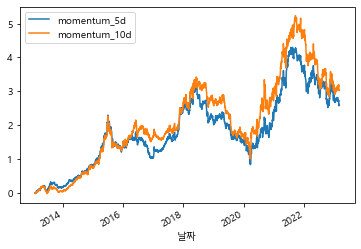

In [67]:
plt.figure(figsize=(10,10))
cumulative_return.plot()
plt.show()